# Feature Engineering
### by: M. Alwi Sukra

import library yang dibutuhkan

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 1. Get data
get data resulting from the preparation step

In [8]:
df_feature = pd.read_pickle("./prep-out.pkl")

In [9]:
df_feature.head()

,subject,class,frame,rEar,lEar,mar
0,60,0,1,0.656274,0.606485,0.025412
1,60,0,2,0.662613,0.606169,0.052597
2,60,0,3,0.723689,0.703438,0.035964
3,60,0,4,0.661827,0.583269,0.052423
4,60,0,5,0.808087,0.842442,0.068713


also get fps info for each video for timing purpose

In [10]:
df_fps = pd.read_csv('D:/datasets/UTA-RLDD/fps/fps.txt', delimiter=';', names=['subject','class','fps'], index_col=False)
df_fps = df_fps.astype({"class": int})
val_dict = dict([(0, 0), (5, 1), (10,2)])
df_fps['class'].replace(val_dict, inplace=True)

In [11]:
df_fps.head()

,subject,class,fps
0,1,0,29.9689
1,1,2,29.9689
2,1,1,29.9689
3,2,0,29.9689
4,2,2,29.9689


print video duration

In [12]:
groups = df_feature.groupby('class')
for idx_class, df_class in groups:
    fps = df_fps.loc[(df_fps['subject'] == 60) & (df_fps['class'] == idx_class)].fps.values[0]
    duration_second = len(df_class)/fps
    frame_for_one_minute = fps*60
    print(f'for video class {idx_class}, frame for one minute = {frame_for_one_minute} so the duration is {duration_second/60} minutes')

for video class 0, frame for one minute = 1791.96 so the duration is 10.075001674144513 minutes
for video class 1, frame for one minute = 1738.812 so the duration is 10.083321256121996 minutes
for video class 2, frame for one minute = 1776.384 so the duration is 10.460013150309843 minutes


### 2. Feature

Get dataframe by class, and set index to timeframe

In [13]:
class_0_df = groups.get_group(0).set_index('frame')
class_1_df = groups.get_group(1).set_index('frame')
class_2_df = groups.get_group(2).set_index('frame')

Function to calculate **perclos** in dataframe

In [14]:
def calculate_perclos(df, window_size, eye_threshold):
    df['eye_closed'] = 0
    df.loc[(df['rEar'] < eye_threshold) & (df['lEar'] < eye_threshold), 'eye_closed'] = 1
    start_frame = 1
    for current_idx in range(window_size+1,len(df)+1):
        stop_frame = current_idx - 1
        df.loc[current_idx,'perclos'] = df.loc[start_frame:stop_frame,'eye_closed'].eq(1).sum() / window_size
        start_frame = start_frame + 1  
    df.drop(['eye_closed'], axis=1, inplace=True)
    return df

function to track **consecutive** eye closed and mouth opened

In [15]:
def track_consecutive(df, eye_threshold, mouth_threshold):
    # default value
    df['btb_eye_closed'] = 0
    df['btb_mouth_opened'] = 0
    # check if eye closed and mouth open
    df.loc[(df['rEar'] < eye_threshold) & (df['lEar'] < eye_threshold), 'btb_eye_closed'] = 1
    df.loc[df['mar'] > mouth_threshold, 'btb_mouth_opened'] = 1
    # track consecutive
    eye = df['btb_eye_closed']
    mouth = df['btb_mouth_opened']
    df['btb_eye_closed'] = eye * (eye.groupby((eye != eye.shift()).cumsum()).cumcount() + 1)
    df['btb_mouth_opened'] = mouth * (mouth.groupby((mouth != mouth.shift()).cumsum()).cumcount() + 1)
    return df

function to compute **microsleep and yawning** event rate (event) occured in some minutes length

In [16]:
def calculate_event_rate(df, window_size, fps, btb_microsleep, btb_yawning):
    start_frame = 1
    for current_idx in range(window_size+1,len(df)+1):
        stop_frame = current_idx - 1
        df.loc[current_idx,'microsleep_rate'] = df.loc[start_frame:stop_frame,'btb_eye_closed'].eq(btb_microsleep).sum() / (window_size/fps)
        df.loc[current_idx,'yawning_rate'] = df.loc[start_frame:stop_frame,'btb_mouth_opened'].eq(btb_yawning).sum() / (window_size/fps)
        start_frame = start_frame + 1  
    return df

function that combine 3 above function into one function

In [17]:
def feature(df, fps, minutes_length, eye_threshold, mouth_threshold, btb_microsleep, btb_yawning):
    window_size = int(fps * 60 * minutes_length)
    df = calculate_perclos(df, window_size, eye_threshold)
    df = track_consecutive(df, eye_threshold, mouth_threshold)
    df = calculate_event_rate(df, window_size, fps, btb_microsleep, btb_yawning)
    df.drop(['btb_eye_closed', 'btb_mouth_opened'], axis=1, inplace=True)
    return df

run function

In [18]:
%%time
# several variable
minutes_length = 3
eye_threshold = 0.5
mouth_threshold = 0.5
fps = df_fps.loc[(df_fps['subject'] == 60) & (df_fps['class'] == 0)].fps.values[0]
btb_microsleep = int(fps) # 1 detik
btb_yawning = int(fps * 6) # 6 detik
# run for each class
class_0_df = feature(class_0_df, fps, minutes_length, eye_threshold, mouth_threshold, btb_microsleep, btb_yawning)
class_1_df = feature(class_1_df, fps, minutes_length, eye_threshold, mouth_threshold, btb_microsleep, btb_yawning)
class_2_df = feature(class_2_df, fps, minutes_length, eye_threshold, mouth_threshold, btb_microsleep, btb_yawning)

Wall time: 3min 46s


In [19]:
class_2_df.head()

,subject,class,rEar,lEar,mar,perclos,microsleep_rate,yawning_rate
frame,,,,,,,,
1,60,2,0.478260,0.529179,0.038887,NaN,NaN,NaN
2,60,2,0.383731,0.513765,0.060113,NaN,NaN,NaN
3,60,2,0.524658,0.578807,0.035523,NaN,NaN,NaN
4,60,2,0.369651,0.433534,0.048409,NaN,NaN,NaN
5,60,2,0.492733,0.513923,0.025608,NaN,NaN,NaN


In [20]:
# container for data going to be plotted
data = {'perclos':np.empty(3, dtype=object), 'microsleep_rate':np.empty(3, dtype=object), 'yawning_rate':np.empty(3, dtype=object)}
keys = [*data]
# clearna
class_0_df.dropna(inplace=True)
class_1_df.dropna(inplace=True)
class_2_df.dropna(inplace=True)
# get data
data['perclos'][0] = class_0_df['perclos'].values
data['perclos'][1] = class_1_df['perclos'].values
data['perclos'][2] = class_2_df['perclos'].values
data['microsleep_rate'][0] = class_0_df['microsleep_rate'].values
data['microsleep_rate'][1] = class_1_df['microsleep_rate'].values
data['microsleep_rate'][2] = class_2_df['microsleep_rate'].values
data['yawning_rate'][0] = class_0_df['yawning_rate'].values
data['yawning_rate'][1] = class_1_df['yawning_rate'].values
data['yawning_rate'][2] = class_2_df['yawning_rate'].values

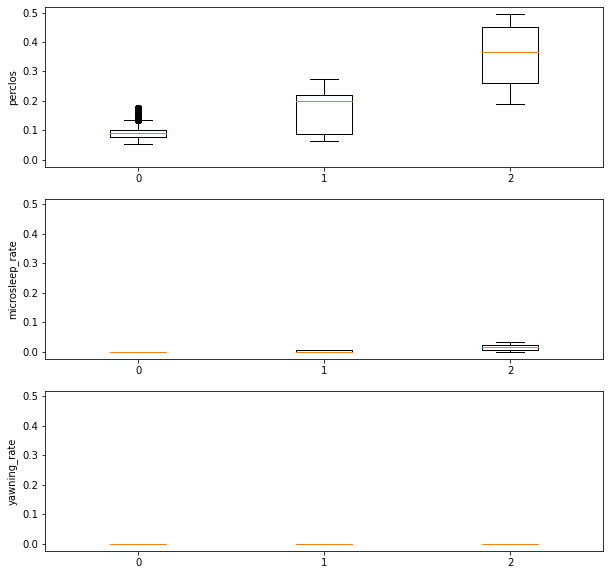

In [21]:
fig, ax = plt.subplots(3, 1, sharey=True, figsize = (10,10))

for i in range(3):
    ax[i].set_xticklabels([0,1,2])
    ax[i].set_ylabel(keys[i])
    ax[i].boxplot(data[keys[i]])